<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/lab_tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Convolutional Neural Network


This is an example of classification of mnist using Convolutional Neural Network.

Import of required library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import Tensor
import torch.nn.functional as F
%matplotlib inline

print('torch version is {}'.format(torch.__version__))
if torch.cuda.is_available():
    print('cuda is available')
else:
    print('cuda is not avaibalbe')

torch version is 1.3.1
cuda is not avaibalbe


Fixed seed value for random numbers.

The initial value of the weight is determined by random numbers. By fixing the seed value of the random number, the initial value of the weight is fixed to prevent different results depending on the initial value.

In [2]:
torch.cuda.manual_seed_all(100100)
torch.manual_seed(100100)
np.random.seed(100100)

Reading dataset.

Image data is stored in x_train and x_test, and labels are stored in y_train and y_test.

This part should be rewritten as appropriate depending on the data set you use.

The input image to the model should have the shape of $(N, C, H, W)$.

$N:$ number of data

$C:$ number of channnel

$H:$ height

$W:$ width

In [3]:
mnist_train = dsets.MNIST(".", download=True, train=True)
x_train = []
y_train = []
x_test = []
y_test = []

mnist_test = dsets.MNIST(".", download=True, train=False)



for i in range(len(mnist_train)):
	x_train.append(np.array(mnist_train[i][0]))
	y_train.append(mnist_train[i][1])

for i in range(len(mnist_test)):
	x_test.append(np.array(mnist_test[i][0]))
	y_test.append(mnist_test[i][1])

#Change shape to (N, C, H, W) by reshape.
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.reshape(len(mnist_train), 1, 28, 28)
x_train = x_train / 255.0

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(len(mnist_test), 1, 28, 28)
x_test = x_test / 255.0


datasize = len(y_train)
datasize_test = len(y_test)

0it [00:00, ?it/s]

100%|█████████▉| 9863168/9912422 [00:29<00:00, 217402.22it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



0it [00:00, ?it/s]


  0%|          | 0/28881 [00:00<?, ?it/s]
32768it [00:01, 29913.03it/s]                           

0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



 89%|████████▉ | 1474560/1648877 [00:06<00:00, 338952.72it/s]
1654784it [00:07, 227817.92it/s]                             

0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



8192it [00:00, 15103.36it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


9920512it [00:39, 217402.22it/s]                             

Define the model structure.

The computation within the convolution layers is regarded as a filtering process of the input image as
\begin{align}
f_{p,q}^{(c)}=h(\sum^{convy-1}_{r=0}\sum^{convx-1}_{s=0}w^{(c)}_{r,s}f^{(c-1)}_{p+r, q+s}+b^{(c)}) \; ,
\end{align}

where $w^{(c)}_{r,s}$ is the weight of the neuron indexed as $(r,s)$ in the $c$-th convolution layer and $b^{(c)}$ is the bias of the $c$-th convolution layer. 

The size of the convolution filter is given as $convx \times convy$. The activation function of each neuron is denoted as $h$. 

Usually, pooling layers are added after the convolution layers. The pooling layer performs downsampling for reducing computational costs and enhancing against micro position changes. 

Fully-connected layers like multi layer perceptron is connected to the convolution layers which is used to construct the classifier. 

In this example, a model of the following structure is defined.


---

convolution layer1:(filtersize:3*3, channel:32)

convolution layer2:(filtersize:3*3, channel:32)

full connected:(128)


---



In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
if torch.cuda.is_available():
  net.cuda()

Definition of loss function.

The cross entropy loss is defined as the following equation.


\begin{align}
E = -\sum_n^N {\boldsymbol t}_n^Tlog(S({\boldsymbol y}_n)) \; 
\end{align}

$S(\cdot)$ is an activation function of the output layer.

${\boldsymbol t_n}$ is a label and ${\boldsymbol y_n}$ is the output of the network.

In multiclass classification, the softmax function is generally used for the activation function of the output layer.

In [5]:
softmax_cross_entropy = nn.CrossEntropyLoss()

Definition of optimizer. 

In the example, the stochastic gradient descent method with momentum (SGD with momentum) is used.

$\mu$ is a learning rate and $\eta$ is a momentum parameter.

\begin{align}
{\boldsymbol w}^{(t+1)} &\leftarrow {\boldsymbol w}^{(t)} + \Delta  {\boldsymbol w}^{(t)} \\
 \Delta  {\boldsymbol w}^{(t)} &= \mu \Delta {\boldsymbol w}^{(t - 1)} - (1-\mu) \eta {\boldsymbol g}^{(t)} \\
 {\boldsymbol g}^{(t)} &= \nabla E({\boldsymbol w}^{(t)})
 \end{align}
 
In addition, regularization terms such as weight decay may be added as necessary to prevent over-learning.

In [6]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

Input data into the model for each mini-batch and perform parameter update.

(1)


In [ ]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

#define batch-size and epoch.
epoch=100
batchsize=100


for epoch in range(1, epoch+1):
	print('epoch', epoch)
	perm = np.random.permutation(datasize)
	for i in range(0, datasize, batchsize):
		#Create mini-batch.
		x_batch = x_train[perm[i:i+batchsize]]
		y_batch = y_train[perm[i:i+batchsize]]
    
		#Convert a numpy array to a tensor to do gradient calculations.
		if torch.cuda.is_available():
			x_batch = torch.from_numpy(x_batch).float().cuda()
			y_batch = torch.from_numpy(y_batch).long().cuda()
		else:
			x_batch = torch.from_numpy(x_batch).float()
			y_batch = torch.from_numpy(y_batch).long()

		#Initialize the stored gradient.
		optimizer.zero_grad()

		#Get the model output for the input mini-batch.
		y = net(x_batch)
    
		#Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
		loss = softmax_cross_entropy(y, y_batch)  
    
		#From loss, calculate the gradient of each parameter.
		loss.backward()

		#Each parameter is updated from the calculated gradient.
		optimizer.step()



	sum_score = 0
	sum_loss = 0
  
	#Evaluate the model with train data.
	for i in range(0, datasize, batchsize):
		x_batch = x_train[i:i+batchsize]
		y_batch = y_train[i:i+batchsize]
		if torch.cuda.is_available():
			x_batch = torch.from_numpy(x_batch).float().cuda()
			y_batch = torch.from_numpy(y_batch).long().cuda()
		else:
			x_batch = torch.from_numpy(x_batch).float()
			y_batch = torch.from_numpy(y_batch).long()
		y = net(x_batch)
		loss = softmax_cross_entropy(y, y_batch)
		sum_loss += float(loss.cpu().data.item()) * batchsize
		_, predict = y.max(1)
		sum_score += predict.eq(y_batch).sum().item()
	print("\ttrain  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
	train_loss.append(sum_loss / datasize)
	train_acc.append(sum_score / datasize)


	sum_score = 0
	sum_loss = 0

  
	#Evaluate the model with test data.
	for i in range(0, datasize_test, batchsize):
		x_batch = x_test[i:i+batchsize]
		y_batch = y_test[i:i+batchsize]
		if torch.cuda.is_available():
			x_batch = torch.from_numpy(x_batch).float().cuda()
			y_batch = torch.from_numpy(y_batch).long().cuda()
		else:
			x_batch = torch.from_numpy(x_batch).float()
			y_batch = torch.from_numpy(y_batch).long()
		y = net(x_batch)
		loss = softmax_cross_entropy(y, y_batch)
		sum_loss += float(loss.cpu().data.item()) * batchsize
		_, predict = y.max(1)
		sum_score += predict.eq(y_batch).sum().item()
	print("\ttest  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
	test_loss.append(sum_loss / datasize_test)
	test_acc.append(sum_score / datasize_test)



epoch 1
	train  mean loss=0.13377783518905442, accuracy=0.9599166666666666
	test  mean loss=0.1244444488780573, accuracy=0.9625
epoch 2
	train  mean loss=0.09117494712894161, accuracy=0.9725166666666667
	test  mean loss=0.08217243601800873, accuracy=0.9734
epoch 3
	train  mean loss=0.0719408898272862, accuracy=0.9791666666666666
	test  mean loss=0.06306819117395207, accuracy=0.9813
epoch 4
	train  mean loss=0.07567688384714226, accuracy=0.97815
	test  mean loss=0.0710721641802229, accuracy=0.9776
epoch 5


Draw a graph of training curve (loss).

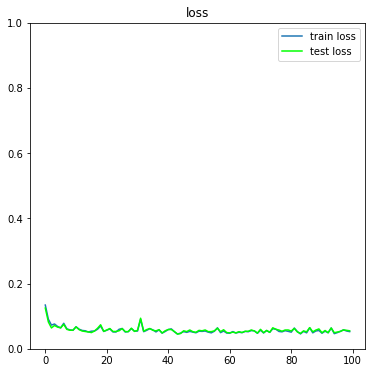

In [8]:
plt.figure(figsize=(6,6))

plt.ylim(0,1.0)
plt.plot(range(epoch), train_loss)
plt.plot(range(epoch), test_loss, c='#00ff00')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.show()

Draw the graph of training curve (accuracy).

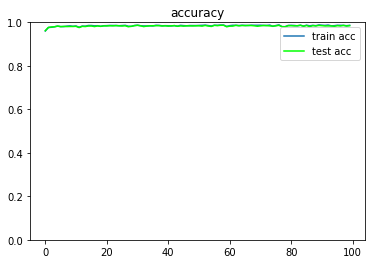

In [20]:
plt.plot(range(epoch), train_acc)
plt.plot(range(epoch), test_acc, c='#00ff00')
plt.ylim(0,1.0)
plt.legend(['train acc', 'test acc'])
plt.title('accuracy')
plt.show()

Next, look at the change in the weight of the middle layer during learning.

First, visualize the connection weights from the input of fully connected layers to the middle layer.

Let's take a look at the unit connection weight, which uses the upper left value of the feature map as input.



In [ ]:
net = Network()
if torch.cuda.is_available():
  net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

In [11]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
weight_num = 10


#define batch-size and epoch.
epoch=100
batchsize=100

#Defines an array that holds the weight for each epoch.
train_weight = np.zeros((epoch, weight_num))

#Specify the weight to be visualized.
#Specify hidden layer unit j.
rum_num = np.array([0,15,30,45,60,75,90,105,120,127])

#Specify input layer unit i.
perm_num = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#The weight w_ij connecting the input layer unit i and the hidden layer unit j is acquired.


for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
      x_batch = torch.from_numpy(x_batch).float()
      y_batch = torch.from_numpy(y_batch).long()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
    
  #Extract weight values from the model.
  weight = net.fc1.weight.cpu().detach().numpy()
  
  for i in range(weight_num):
    weight0 = weight[rum_num[i]][perm_num[i]]
    train_weight[epoch-1][i] = weight0


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
      x_batch = torch.from_numpy(x_batch).float()
      y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttrain  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
      x_batch = torch.from_numpy(x_batch).float()
      y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttest  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


epoch 1
	train  mean loss=0.49317943419019383, accuracy=0.85885
	test  mean loss=0.47729572385549546, accuracy=0.8664
epoch 2
	train  mean loss=0.305145058495303, accuracy=0.9092166666666667
	test  mean loss=0.29437801986932755, accuracy=0.9146
epoch 3
	train  mean loss=0.25247206637014946, accuracy=0.9253
	test  mean loss=0.24415815107524394, accuracy=0.9295
epoch 4
	train  mean loss=0.2045735833266129, accuracy=0.9385833333333333
	test  mean loss=0.1906883814558387, accuracy=0.9417
epoch 5
	train  mean loss=0.17036522176737587, accuracy=0.9501833333333334
	test  mean loss=0.16501481969840825, accuracy=0.9505
epoch 6
	train  mean loss=0.1480173056013882, accuracy=0.9562
	test  mean loss=0.13894010924734176, accuracy=0.9586
epoch 7
	train  mean loss=0.1297691342405354, accuracy=0.9615833333333333
	test  mean loss=0.12213899482041597, accuracy=0.9634
epoch 8
	train  mean loss=0.12316606126104791, accuracy=0.9634333333333334
	test  mean loss=0.11410150443669409, accuracy=0.9649
epoch 9
	

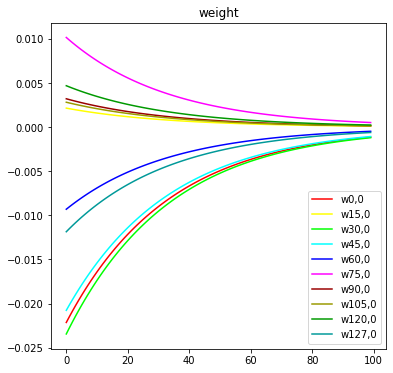

In [12]:
plt.figure(figsize=(6,6))
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

#Plot the obtained weights on a graph.
train_weight = train_weight.transpose(1,0)
for i in range(weight_num):
  plt.plot(range(epoch), train_weight[i], c=c[i])
plt.legend(['w0,0', 'w15,0', 'w30,0', 'w45,0', 'w60,0', 'w75,0', 'w90,0', 'w105,0', 'w120,0', 'w127,0'])
plt.title('weight')
plt.show()

The unit connection weights are all close to 0.

That is, the value of index 0 unit in the input layer is rarely used.

Next, visualize the filter weight of the first layer of convolution.

In [ ]:
net = Network()
if torch.cuda.is_available():
  net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [14]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]




#define batch-size and epoch.
epoch=100
batchsize=100

#Specify the weight to be visualized.
#Specify the input channel.
inputc_num = np.array([0,0,0])

#Specify the output channel.
outputc_num = np.array([0,16,31])

#Defines an array that holds the weight for each epoch.
weight_num = int(len(inputc_num))
k_size = int(net.conv1.weight.cpu().detach().numpy().shape[2])
train_weight = np.zeros((weight_num, epoch, k_size*k_size))

for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
  #Extract weight values from the model.
  weight = net.conv1.weight.cpu().detach().numpy()
  
  for i in range(weight_num):
    weight0 = weight[outputc_num[i]][inputc_num[i]]
    weight0 = weight0.flatten()
    train_weight[i][epoch-1] = weight0


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttrain  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttest  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


epoch 1
	train  mean loss=0.1316259328989933, accuracy=0.9612333333333334
	test  mean loss=0.12459794435184449, accuracy=0.9627
epoch 2
	train  mean loss=0.0984731398926427, accuracy=0.9698166666666667
	test  mean loss=0.08880754084093496, accuracy=0.9724
epoch 3
	train  mean loss=0.07118457781538988, accuracy=0.9795333333333334
	test  mean loss=0.06689567748457194, accuracy=0.9792
epoch 4
	train  mean loss=0.07152167497202754, accuracy=0.9800666666666666
	test  mean loss=0.06828167389146983, accuracy=0.9796
epoch 5
	train  mean loss=0.06575518263038248, accuracy=0.981
	test  mean loss=0.06151920441538095, accuracy=0.9801
epoch 6
	train  mean loss=0.05575652504184594, accuracy=0.9849
	test  mean loss=0.05637151584029198, accuracy=0.9829
epoch 7
	train  mean loss=0.06524489587172866, accuracy=0.9814333333333334
	test  mean loss=0.06268421180546284, accuracy=0.983
epoch 8
	train  mean loss=0.0588362563525637, accuracy=0.98335
	test  mean loss=0.05902592411031946, accuracy=0.9821
epoch 9


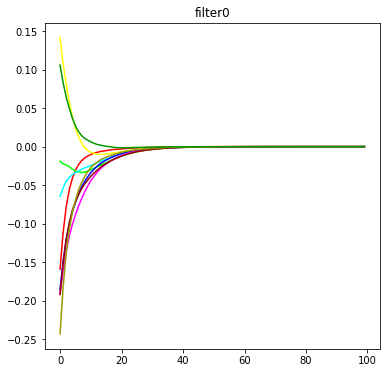

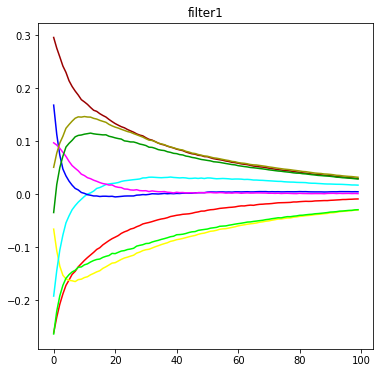

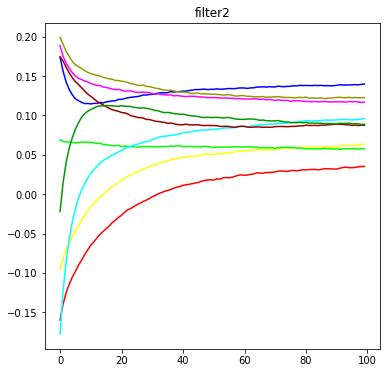

In [15]:
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

for i in range(weight_num):
  plt.figure(figsize=(6,6))
  p = train_weight[i]
  p = p.transpose(1,0)
  for j in range(k_size*k_size):
    plt.plot(range(epoch), p[j], c=c[j])
  plt.title('filter%d'%i)
  plt.show()

In [ ]:
net = Network()
if torch.cuda.is_available():
  net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [17]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]



#define batch-size and epoch.
epoch=100
batchsize=100

#Specify the weight to be visualized.
#Specify the input channel.
inputc_num = np.array([0,16,25])

#Specify the output channel.
outputc_num = np.array([0,16,25])

weight_num = int(len(inputc_num))
k_size = int(net.conv2.weight.cpu().detach().numpy().shape[2])

train_weight = np.zeros((weight_num, epoch, k_size*k_size))

for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
  #Extract weight values from the model.
  weight = net.conv2.weight.cpu().detach().numpy()
  
  for i in range(weight_num):
    weight0 = weight[outputc_num[i]][inputc_num[i]]
    weight0 = weight0.flatten()
    train_weight[i][epoch-1] = weight0


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttrain  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    if torch.cuda.is_available():
      x_batch = torch.from_numpy(x_batch).float().cuda()
      y_batch = torch.from_numpy(y_batch).long().cuda()
    else:
        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch).long()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("\ttest  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


epoch 1
	train  mean loss=0.13636289259418846, accuracy=0.9601
	test  mean loss=0.12464341153856368, accuracy=0.9619
epoch 2
	train  mean loss=0.08356011688243598, accuracy=0.9763833333333334
	test  mean loss=0.07743085539666936, accuracy=0.9765
epoch 3
	train  mean loss=0.07773225823882968, accuracy=0.9774
	test  mean loss=0.07290936014149338, accuracy=0.9788
epoch 4
	train  mean loss=0.0681411638072071, accuracy=0.9797333333333333
	test  mean loss=0.06518874638946727, accuracy=0.9797
epoch 5
	train  mean loss=0.0623011307635655, accuracy=0.98275
	test  mean loss=0.061236456213518975, accuracy=0.9829
epoch 6
	train  mean loss=0.06585694248011957, accuracy=0.9806666666666667
	test  mean loss=0.06427983606001363, accuracy=0.9802
epoch 7
	train  mean loss=0.06893837697803974, accuracy=0.9804166666666667
	test  mean loss=0.0652314255386591, accuracy=0.9815
epoch 8
	train  mean loss=0.06350342961338659, accuracy=0.9826833333333334
	test  mean loss=0.0643582730263006, accuracy=0.9807
epoch 

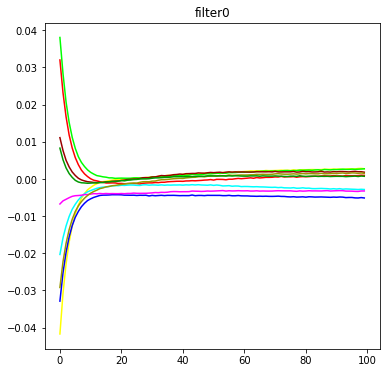

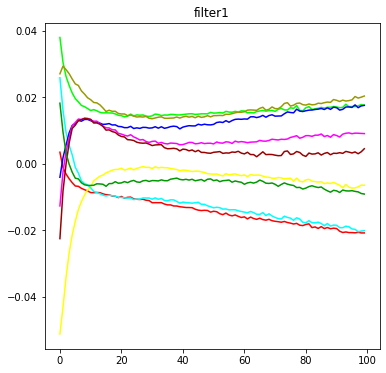

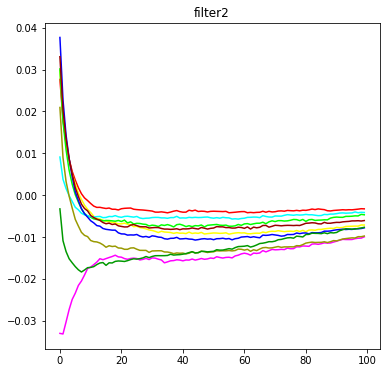

In [18]:
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

#Plot the obtained weights on a graph.
for i in range(weight_num):
  plt.figure(figsize=(6,6))
  p = train_weight[i]
  p = p.transpose(1,0)
  for j in range(k_size*k_size):
    plt.plot(range(epoch), p[j], c=c[j])
  plt.title('filter%d'%i)
  plt.show()

It may be the effect of weight decay that some filter weight values are approaching zero.

You can also see the change in weight when not using weight decay.

Next, let's take out the feature map of the middle layer.

Extract the feature map obtained from the first layer of convolution.

In [ ]:
result = np.zeros((datasize, 32, 28, 28))

for i in range(0, datasize, batchsize):
	x_batch = x_train[i:i+batchsize]
	if torch.cuda.is_available():
		x_batch = torch.from_numpy(x_batch).float().cuda()
	else:
		x_batch = torch.from_numpy(x_batch).float()
	fmap = net.conv1(x_batch)
	result[i:i+batchsize] = fmap.cpu().detach().numpy()


NameError: ignored

The extracted feature map is displayed in as image.

In [ ]:
#Specify the index of the image you want to display.
index = 250

for i in range(32):
  pic = result[index]
  pic = pic[i]
  pic= pic.reshape((28,28))
  plt.imshow(pic)
  plt.gray()
  plt.show()


Next, extract the feature map obtained from the second layer of convolution.

In [ ]:
result = np.zeros((datasize, 32, 28, 28))

for i in range(0, datasize, batchsize):
	x_batch = x_train[i:i+batchsize]
	if torch.cuda.is_available():
		x_batch = torch.from_numpy(x_batch).float().cuda()
	else:
		x_batch = torch.from_numpy(x_batch).float()
	fmap = net.conv1(x_batch)
	fmap = net.conv2(fmap)
	result[i:i+batchsize] = fmap.cpu().detach().numpy()


In [ ]:
#Specify the index of the image you want to display.
index = 250


for i in range(32):
  pic = result[index]
  pic = pic[i]
  pic= pic.reshape((28,28))
  plt.imshow(pic)
  plt.gray()
  plt.show()

Each feature map shows that edge extraction has been performed.